# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  

In [1]:
# Standard libraries
# import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
# from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import PiCOLoss, IRLoss, UpperBoundWeakProperLoss
# from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
# dataset_name = 'Cifar10'
dataset_name = 'mnist'
Data = Data_handling(
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42,
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y

print(f"Number of classes: {Data.num_classes}")
print(f"Array of targets: \n {Data.test_dataset.targets}")
df = pd.DataFrame(
    Data.train_dataset.data.numpy(),
    # columns=[f'feature_{i}' 
    columns=[f'x_{i}' 
             for i in range(Data.train_dataset.data.shape[1])])

# Add target column
df['target'] = [i for i in Data.train_dataset.targets.numpy()]

# Print 3 rows
print(df.head(3))

Number of classes: 10
Array of targets: 
 tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
   x_0  x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  x_9  ...  x_775  x_776  x_777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   x_778  x_779  x_780  x_781  x_782  x_783  \
0    0.0    0.0    0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0    0.0    0.0    0.0   

                                              target  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
1  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 1

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [4]:
# Generate transition matrix M
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
# weakener.generate_M(model_class='pll', corr_p=0.2)
weakener.generate_M(model_class='unif_noise', corr_p=0.5) # For noisy labels
print(f"Generated M matrix:\n"
      f"{np.array2string(weakener.M, precision=4, suppress_small=True)}")

# Generate weak labels z
true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)
z = weakener.generate_weak(
    true_onehot, compute_w=True, compute_Y=False, compute_Y_opt=False,
    compute_Y_conv=False, compute_Y_opt_conv=False)
print(f"Generated weak labels z:\n{z}")

# Compute virtual labels
print("Computing virtual labels...")
# Since z[i] is an integer, row i must contain the z[i]-th row of weakener.Z
virtual_labels = weakener.Z[z]

# Add weak and virtual labels to the dataset
Data.include_weak(z)
Data.include_virtual(virtual_labels, initial_weight=1/Data.num_classes)

# Get dataloaders with weak labels and indices
train_loader, test_loader = Data.get_dataloader(
    weak_labels='all', get_index=True)

Generated M matrix:
[[0.5    0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.5    0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.5    0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.5    0.0556 0.0556 0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.5    0.0556 0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.0556 0.5    0.0556 0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.5    0.0556 0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.5    0.0556 0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.5    0.0556]
 [0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.0556 0.5   ]]
Generated weak labels z:
tensor([5, 4, 4,  ..., 3, 4, 5], dtype=torch.int32)
Computing virtual labels...


In [5]:
batch = next(iter(train_loader))
xb, wb, vb, cb, yb, ib = batch
print(f"Inputs batch: shape {xb.shape}")
print(f"Weak (partial) labels: shape {wb.shape}, first row: {wb[0]}")
print(f"Virtual labels: shape {vb.shape}, first row: {vb[0]}")
print(f"Weights: shape {cb.shape}, first row: {cb[0]}")
print(f"True one-hot labels shape: {yb.shape}, first row: {yb[0]}")
print(f"Indices batch: shape {ib.shape}, first row: {ib[0]}")

Inputs batch: shape torch.Size([64, 784])
Weak (partial) labels: shape torch.Size([64]), first row: 5
Virtual labels: shape torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=torch.float64)
Weights: shape torch.Size([64, 10]), first row: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
True one-hot labels shape: torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Indices batch: shape torch.Size([64]), first row: 0


In [6]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'x_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]




1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

In [7]:
# ##########################
# Define model and optimizer
def get_model(Data, opt_alg='adam', lr=1e-6, momentum=0.9):
    """ Define model and optimizer
    Parameters
        Data: dataset object with num_classes and num_features attributes
    Returns
        model: the neural network model
        optimizer: the optimizer
    """

    model = MLP(
        input_size=Data.num_features,
        hidden_sizes=[],
        output_size=Data.num_classes,
        dropout_p=0,
        bn=False,
        activation='relu')

    if opt_alg == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt_alg == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_alg}") 

    return model, optimizer

# ########################
# Visualization of results
def plot_results(results_df):
    """ Plot training results
    Parameters
        results_df: DataFrame with training results
    """

    # Set up a wide figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss curves
    ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
    ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Now we define a method with the steps of each simulation to test a learning algorithm

In [8]:
def run_simulation(Data, loss, num_epochs=10, optimizer_name='adam', 
                   loss_code=None, pseudolabel_model=None, lr=1e-6, corr_p=0.2,
                   phi=0.8):
    """Run a training simulation with the specified parameters.

    Parameters
    ----------
    Data : dataset object
        The dataset object containing training and test data.
    loss : loss function object
        The loss function to use for training.
    num_epochs : int, optional
        The number of training epochs (default is 10).
    optimizer_name : str, optional
        The name of the optimizer to use (default is 'adam').
    loss_code : str, optional
        A code representing the loss function (for metadata) (default is None).
    pseudolabel_model : str, optional
        A string indicating the pseudolabel model used (for metadata)
        (default is None).
    lr : float, optional
        The learning rate for the optimizer (default is 1e-6).
    corr_p : float, optional
        The corruption probability used in the weak label generation 
        (for metadata) (default is 0.2).
    phi : float, optional
        The phi parameter for the training loop (default is 0.8).
    """

    # 1. Get model and optimizer
    model, optimizer = get_model(Data, opt_alg=optimizer_name, lr=lr)

    # 2. Run the training + evaluation loop
    model, results_df = train_and_evaluate(
        model, train_loader, test_loader, optimizer, loss, num_epochs,
        phi=phi, pseudolabel_model=pseudolabel_model)

    # 3. Save simultation attributes in a metadata dictionary
    metadata = {'pseudo_label_model': pseudolabel_model, 'loss_name': loss_code, 
                'corr_p': corr_p, 'optimizer': type(optimizer).__name__,
                'initial_lr': optimizer.param_groups[0]['lr'], 'phi': phi}
    print(pd.DataFrame([metadata]).T)

    # 4. View the epoch‐by‐epoch results
    plot_results(results_df)

    return model, optimizer, metadata, results_df

In [9]:
# #####################################
# Common parameters for all simulations

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training parameters
num_epochs = 10
optimizer_name = 'adam'
lr = 1e-6

Using device: cpu


## Running experiments  

Initializing MLP model with 784 inputs, [] hidden sizes, and 10 outputs.
Epoch 10/10: Train Loss: 0.0074, Train Acc: 0.9134, Test Acc: 0.9169, Train Detached Loss: 0.0053, Test Detached Loss: 0.0051, Learning Rate: 0.000001, Epoch Time: 1.42 seconds
                                0
pseudo_label_model             IR
loss_name           cross_entropy
corr_p                        0.2
optimizer                    Adam
initial_lr               0.000001
phi                           0.8


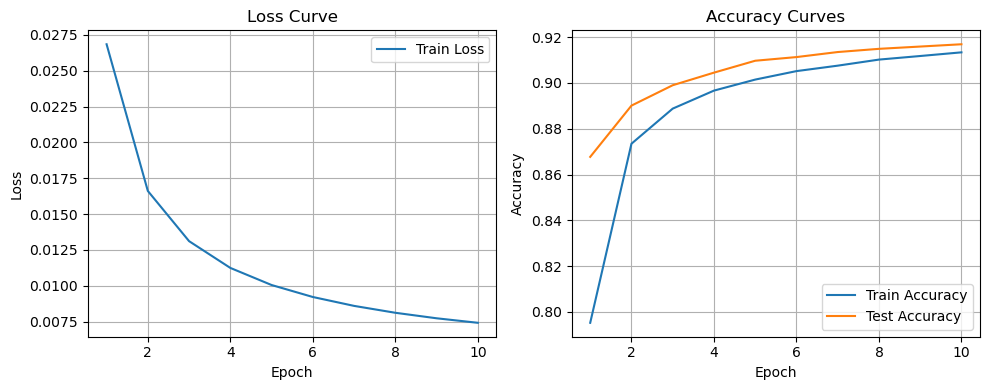

,epoch,pseudolabel_model,train_loss,train_acc,test_acc,train_detached_loss,test_detached_loss,actual_lr,epoch_time
0,1,IR,0.026842,0.795217,0.8677,0.011316,0.011000,0.000001,1.510204
1,2,IR,0.016614,0.873450,0.8901,0.008450,0.008149,0.000001,1.518850
2,3,IR,0.013114,0.888783,0.8990,0.007280,0.007001,0.000001,1.435742
3,4,IR,0.011248,0.896650,0.9045,0.006627,0.006366,0.000001,1.618325
4,5,IR,0.010056,0.901467,0.9097,0.006208,0.005963,0.000001,1.461916
5,6,IR,0.009221,0.905167,0.9113,0.005917,0.005686,0.000001,1.447494
6,7,IR,0.008601,0.907550,0.9135,0.005704,0.005485,0.000001,1.426009
7,8,IR,0.008121,0.910200,0.9149,0.005541,0.005334,0.000001,1.431316
8,9,IR,0.007737,0.911767,0.9159,0.005413,0.005217,0.000001,1.445708
9,10,IR,0.007422,0.913367,0.9169,0.005311,0.005125,0.000001,1.420011


In [10]:
# #################
# Testing IR Loss

loss_code = "cross_entropy"
loss = IRLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'IR'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p)

results_df.head(num_epochs)


In [ ]:
# #################
# Testing PiCO Loss

loss_code = "cross_entropy"
loss = PiCOLoss(loss_code=loss_code)
pseudolabel_model = 'PiCO'
phi = 0.8

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# #################
# Marginal Chain

loss_code = "cross_entropy"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)


In [ ]:
# #################
# Forward Proper Loss

loss_code = "cross_entropy"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# ############
# Majorization-Minimization (Uppder bound)

loss_code = "cross_entropy"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# #################
# Marginal Chain

loss_code = "ps_2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "ps_2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "ps_2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'


model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
# ##############
# Marginal Chain

loss_code = "tsallis_0.2"
loss = MarginalChainProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MC'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)

In [ ]:
loss_code = "tsallis_0.2"
loss = ForwardProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'FWD'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

In [ ]:
loss_code = "tsallis_0.2"
loss = UpperBoundWeakProperLoss(weakener.M, loss_code=loss_code)
pseudolabel_model = 'MM'

model, optimizer, metadata, results_df = run_simulation(
    Data, loss, num_epochs=num_epochs, optimizer_name=optimizer_name, 
    loss_code=loss_code, pseudolabel_model=pseudolabel_model, lr=lr,
    corr_p=corr_p, phi=phi)

results_df.head(num_epochs)